<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim; font-size:200%;'> Code Modules, Helpful Functions, Styling, and Links</h1>
#### [Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/blob/master/DL_PP5) & [Colaboratory Version](https://colab.research.google.com/drive/1Tt3qZePsf2P6kNNao-hQ58DlG71Abj5a)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d');
body {background-color:#f7e8e8;} 
a,h4 {color:crimson; font-family:Roboto;}
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:crimson;} 
div.input_prompt {color:firebrick;} 
div.output_area pre,div.output_subarea {font-size:15px; color:crimson}
div.output_stderr pre {background-color:#f7e8e8;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from skimage.transform import resize
from skimage import color, measure
from IPython.core.magic import register_line_magic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
fw='weights.decor.hdf5'
n=np.random.choice(484,size=6,replace=False)
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0


In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto')\
           .fit(x.reshape(-1,1))\
           .transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
def history_plot2(fit_history):
    lk=[1,2,3]
    keys=list(fit_history.history.keys())[8:]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='valid 1')
    pl.plot(fit_history.history[keys[1]],
            color='firebrick',label='valid 2')
    pl.plot(fit_history.history[keys[2]],
            color='#FF355E',label='valid 3')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[3]],
            color='crimson',label='valid 1')
    pl.plot(fit_history.history[keys[4]],
            color='firebrick',label='valid 2')
    pl.plot(fit_history.history[keys[5]],
            color='#FF355E',label='valid 3')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()

<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim; font-size:200%;'> Data Loading and Exploration </h1>

In [4]:
data=pd.read_csv("../input/decor.csv")
data.loc[n]

,country_label,country,decor_label,decor,type_label,type,file
38,1,Russia,1,Gzhel,2,product,01_01_2_006.png
113,1,Russia,2,Khokhloma,1,pattern,01_02_1_026.png
245,1,Russia,3,Gorodets,2,product,01_03_2_027.png
213,1,Russia,3,Gorodets,1,pattern,01_03_1_030.png
34,1,Russia,1,Gzhel,2,product,01_01_2_002.png
309,2,Poland,4,Wycinanki łowickie,2,product,02_04_2_004.png


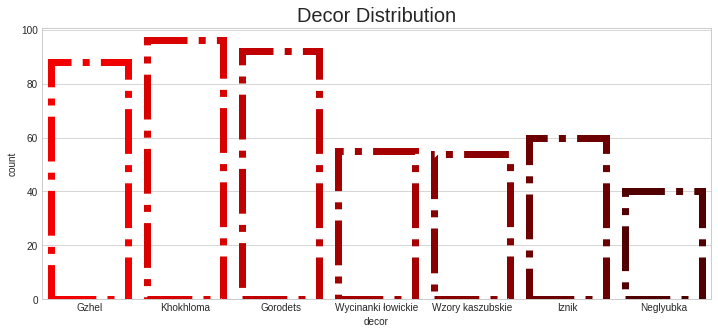

In [5]:
pl.figure(figsize=(12,5))
sn.countplot(x="decor",data=data,facecolor=(0,0,0,0),
             linewidth=7,linestyle='-.',
             edgecolor=sn.color_palette("flag",7))
pl.title('Decor Distribution',fontsize=20);

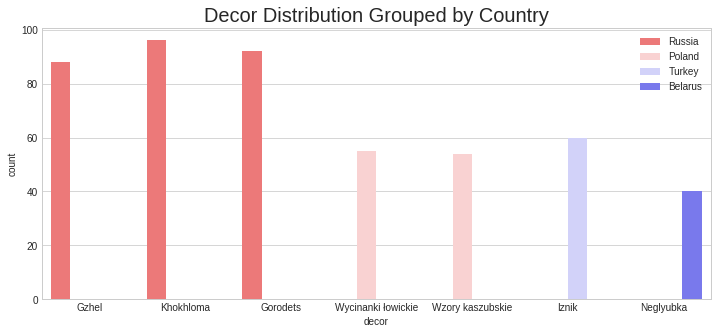

In [6]:
pl.figure(figsize=(12,5))
sn.countplot(x="decor",hue="country",data=data,palette='bwr_r')
pl.legend(loc=1); ti='Decor Distribution Grouped by Country'
pl.title(ti,fontsize=20);

In [7]:
print(set(data['decor']))
print(set(data['country']))

{'Wzory kaszubskie', 'Khokhloma', 'Wycinanki łowickie', 'Gorodets', 'Iznik', 'Gzhel', 'Neglyubka'}
{'Turkey', 'Russia', 'Poland', 'Belarus'}


In [8]:
f=h5py.File('../input/DecorColorImages.h5','r')
keys=list(f.keys())
[countries,decors,images,types]=\
[np.array(f[keys[i]]) for i in range(4)]
sh=[el.shape for el in [countries,decors,images,types]]
pd.DataFrame(sh,index=keys)

,0,1,2,3
countries,485,NaN,NaN,NaN
decors,485,NaN,NaN,NaN
images,485,150.0,150.0,3.0
types,485,NaN,NaN,NaN


<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim; font-size:200%;'> Implementation of Preprocessing Functions </h1>

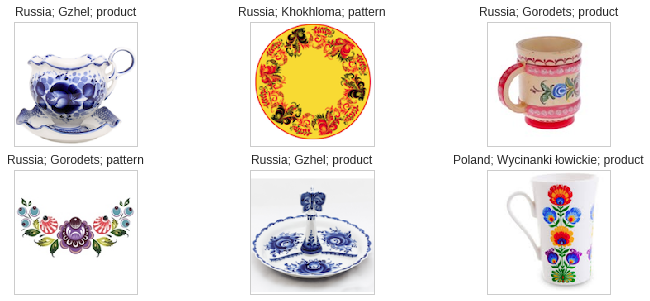

In [9]:
images=images/255
fig=pl.figure(figsize=(12,5))
for i,idx in enumerate(n):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(images[idx])
    ax.set_title(data['country'][idx]+'; '+\
                 data['decor'][idx]+'; '+data['type'][idx])

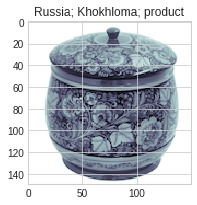

In [10]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
pl.figure(figsize=(3,3))
n=np.random.choice(484,size=1,replace=False)[0]
pl.imshow(images[n])
pl.title(data['country'][n]+'; '+\
         data['decor'][n]+'; '+data['type'][n])
pl.imshow(gray_images[n],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [11]:
ccountries,cdecors,ctypes=\
ohe(countries),ohe(decors),ohe(types)
ctargets=np.concatenate((ccountries,cdecors),axis=1)
ctargets=np.concatenate((ctargets,ctypes),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              ccountries.shape,cdecors.shape,
              ctypes.shape,ctargets.shape])

,0,1,2,3
0,485,150,150.0,3.0
1,485,150,150.0,1.0
2,485,4,NaN,NaN
3,485,7,NaN,NaN
4,485,2,NaN,NaN
5,485,13,NaN,NaN


In [12]:
# spliting the data 
# Color Images / Countries 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,ccountries)
# Grayscaled Images / Countries 
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,ccountries)
# Color Images / Decors 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cdecors)
# Grayscaled Images / Decors 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cdecors)
# Color Images / Multi-Label Targets
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Targets 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5,
 x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame(sh)

,0,1,2,3
0,388,150,150.0,3.0
1,388,4,NaN,NaN
2,48,150,150.0,3.0
3,48,4,NaN,NaN
4,49,150,150.0,3.0
5,49,4,NaN,NaN
6,388,150,150.0,3.0
7,388,7,NaN,NaN
8,48,150,150.0,3.0
9,48,7,NaN,NaN


In [13]:
y_train5_list=[y_train5[:,:4],y_train5[:,4:11],y_train5[:,11:]]
y_test5_list=[y_test5[:,:4],y_test5[:,4:11],y_test5[:,11:]]
y_valid5_list=[y_valid5[:,:4],y_valid5[:,4:11],y_valid5[:,11:]]
y_train6_list=[y_train6[:,:4],y_train6[:,4:11],y_train6[:,11:]]
y_test6_list=[y_test6[:,:4],y_test6[:,4:11],y_test6[:,11:]]
y_valid6_list=[y_valid6[:,:4],y_valid6[:,4:11],y_valid6[:,11:]]

<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim; font-size:200%;'> Image Contours </h1>
#### Just for fun

In [14]:
@register_line_magic
def vector(number):
    example=images[int(number)]
    gray_example=color.colorconv.rgb2grey(example)
    contours=measure.find_contours(gray_example,.85)
    pl.figure(figsize=(8,8))
    pl.gca().invert_yaxis()
    for n,contour in enumerate(contours):
        pl.plot(contour[:,1],contour[:,0],lw=1)

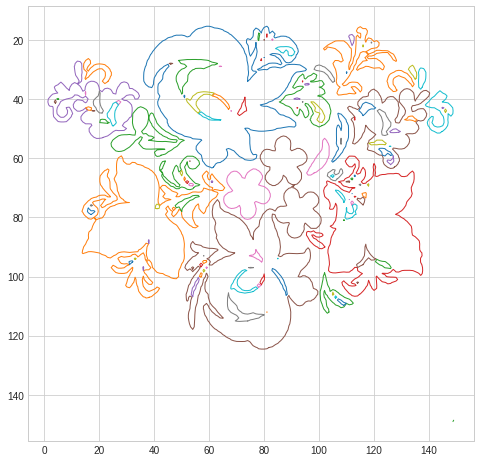

In [15]:
%vector 106

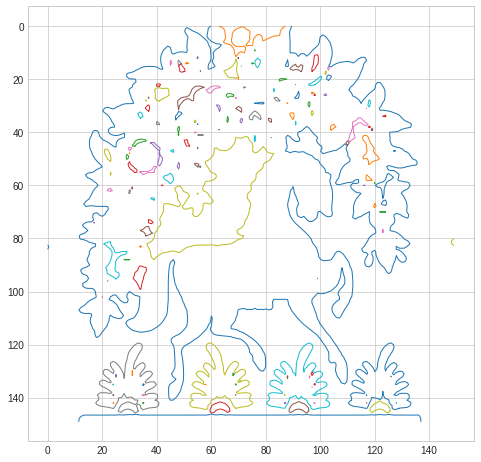

In [16]:
%vector 200

<h1 class='font-effect-3d' style='color:firebrick; font-family:Akronim; font-size:200%;'> One Simple CNN Example </h1>

In [17]:
# Color Images / Decors 
def model(leaky_alpha):
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same', 
                     input_shape=x_train3.shape[1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))   
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(.25))     
    model.add(Dense(7))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
model=model(float(.005))  

In [18]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=15,verbose=2)
history=model.fit(x_train3,y_train3,epochs=100,batch_size=16,verbose=2,
                  validation_data=(x_valid3,y_valid3),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 388 samples, validate on 48 samples
Epoch 1/100
 - 43s - loss: 1.8939 - acc: 0.2706 - val_loss: 2.0103 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 2.01031, saving model to weights.decor.hdf5
Epoch 2/100
 - 42s - loss: 1.5272 - acc: 0.4124 - val_loss: 1.3703 - val_acc: 0.5208

Epoch 00002: val_loss improved from 2.01031 to 1.37029, saving model to weights.decor.hdf5
Epoch 3/100
 - 42s - loss: 1.3510 - acc: 0.5258 - val_loss: 1.4443 - val_acc: 0.5000

Epoch 00003: val_loss did not improve
Epoch 4/100
 - 42s - loss: 0.9149 - acc: 0.6753 - val_loss: 1.1567 - val_acc: 0.5833

Epoch 00004: val_loss improved from 1.37029 to 1.15669, saving model to weights.decor.hdf5
Epoch 5/100
 - 42s - loss: 0.7782 - acc: 0.7062 - val_loss: 1.0163 - val_acc: 0.6042

Epoch 00005: val_loss improved from 1.15669 to 1.01632, saving model to weights.decor.hdf5
Epoch 6/100
 - 42s - loss: 0.6679 - acc: 0.7345 - val_loss: 0.7526 - val_acc: 0.7292

Epoch 00006: val_loss improved from 1.016

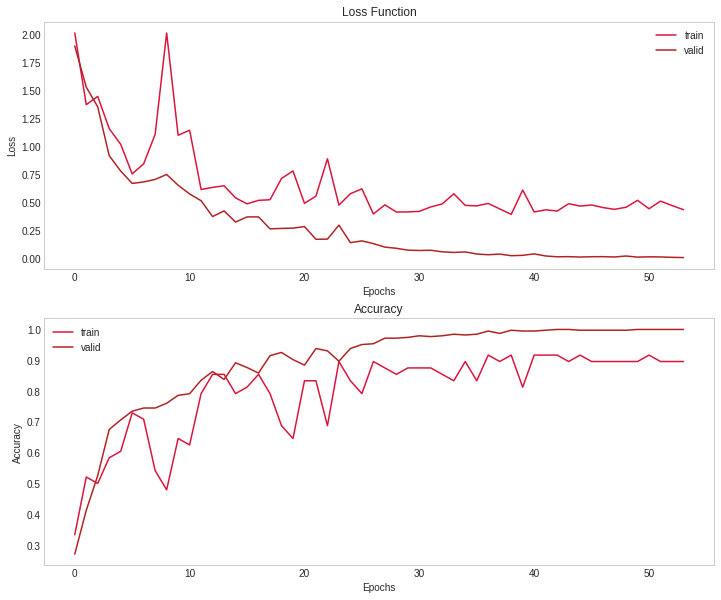

49/49 [==============================] - 2s 34ms/step


[0.48323239598955425, 0.897959186106312]

In [19]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)